# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups             
Sample_030  Q9Y696                        14.412
Sample_053  Q9H6B4                        14.451
Sample_163  P55268                        15.847
Sample_144  B1AJR6;B1AJR9;B1AJS0;O14522   13.968
Sample_010  Q9HAT2                        17.648
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                          
Sample_140  Q9NS84                                     12.010
Sample_091  K7EPJ5;O60291;O60291-2;O60291-3;O60291-4   13.753
Sample_140  P31321                                     13.498
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.269
            A0A075B6Q5                 13.253
            A0A075B6R2                 12.235
            A0A075B6S5                 12.980
            A0A087WSY4                 12.789
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.316
            Q9UI40;Q9UI40-2            11.662
            Q9UIW2                     13.186
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.300
            Q9UP79                     13.013
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.068,15.050,16.842,19.863,16.202,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.823,19.067,...,15.528,15.576,14.390,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.867,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.437,17.705,17.039,15.539,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.385,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.334,15.345,17.084,18.708,14.249,19.433,12.034,11.418
Sample_207,15.739,16.877,15.469,16.898,14.601,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.269,...,16.012,15.178,13.646,15.050,16.842,19.863,12.085,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.470,19.067,16.188,...,15.528,15.576,12.787,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.595,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.828,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.205,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.421,15.345,17.084,18.708,14.249,19.433,12.377,13.989
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 416.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.46it/s]

100%|██████████| 3/3 [00:00<00:00,  2.98it/s]

100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.87it/s]

100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.02it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.88it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.40it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.48it/s]

100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.08it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.95it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.93it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.91it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.19it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.52it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.13it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.89it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.85it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.70it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.54it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.41it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.05it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.09it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.87it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.81it/s]

100%|██████████| 9/9 [00:02<00:00,  2.84it/s]

100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.38it/s]

 30%|███       | 3/10 [00:00<00:01,  3.56it/s]

 40%|████      | 4/10 [00:01<00:01,  3.08it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.01it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.08it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.09it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.98it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.94it/s]

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.45it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.57it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.23it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.95it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.67it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.53it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.28it/s]

100%|██████████| 11/11 [00:03<00:00,  2.27it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.34it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.56it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.49it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.53it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.60it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.58it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.70it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

100%|██████████| 12/12 [00:04<00:00,  2.70it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.05it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.88it/s]

 31%|███       | 4/13 [00:01<00:02,  3.40it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.78it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.65it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.31it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.21it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.22it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.08it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.11it/s]

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.67it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.69it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.16it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.95it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.01it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.15it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.28it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.99it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.02it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.01it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.10it/s]

100%|██████████| 14/14 [00:06<00:00,  2.12it/s]

100%|██████████| 14/14 [00:06<00:00,  2.17it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.53it/s]

 20%|██        | 3/15 [00:00<00:03,  3.15it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.69it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.74it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.68it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.57it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.59it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.56it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.62it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.17it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.96it/s]

100%|██████████| 15/15 [00:06<00:00,  1.79it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.052 0.018          0.576 0.446       0.076   
2             0.005 0.003      0.058 0.019          0.751 0.088       0.688   
3             0.004 0.002      0.056 0.017          0.746 0.090       0.675   
4             0.005 0.003      0.054 0.015          0.743 0.097       0.673   
5             0.004 0.002      0.054 0.013          0.730 0.097       0.686   
6             0.004 0.000      0.050 0.010          0.721 0.095       0.681   
7             0.004 0.002      0.049 0.008          0.771 0.095       0.775   
8             0.004 0.002      0.048 0.008          0.779 0.092       0.781   
9             0.004 0.000      0.043 0.005          0.785 0.097       0.773   
10            0.005 0.004      0.081 0.027          0.781 0.094       0.773   
11            0.004 0.001      0.050 0.014          0.803 0.082       0.801   
12            0.005 0.004      0.059 0.021          0.796 0.079       0.798   
13            0.007 0.005      0.068 0.024          0.793 0.081       0.788   
14            0.005 0.003      0.060 0.025          0.790 0.084       0.792   
15            0.006 0.005      0.069 0.028          0.787 0.087       0.774   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.076   0.129 0.119                  0.531 0.035        0.845   
2          0.097   0.712 0.066                  0.757 0.051        0.834   
3          0.102   0.702 0.069                  0.750 0.054        0.829   
4          0.101   0.700 0.072                  0.748 0.056        0.824   
5          0.095   0.703 0.076                  0.748 0.062        0.832   
6          0.106   0.694 0.078                  0.741 0.062        0.830   
7          0.102   0.768 0.074                  0.801 0.062        0.888   
8          0.109   0.774 0.075                  0.807 0.063        0.890   
9          0.102   0.773 0.070                  0.806 0.059        0.890   
10         0.106   0.771 0.072                  0.805 0.060        0.891   
11         0.102   0.798 0.070                  0.827 0.060        0.898   
12         0.089   0.793 0.062                  0.823 0.053        0.898   
13         0.087   0.787 0.063                  0.817 0.054        0.897   
14         0.101   0.786 0.068                  0.817 0.059        0.896   
15         0.100   0.776 0.069                  0.809 0.059        0.895   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.820 0.089        210.000 0.000  
2          0.058                  0.777 0.082        210.000 0.000  
3          0.060                  0.771 0.088        210.000 0.000  
4          0.060                  0.767 0.088        210.000 0.000  
5          0.058                  0.779 0.080        210.000 0.000  
6          0.058                  0.779 0.081        210.000 0.000  
7          0.050                  0.859 0.066        210.000 0.000  
8          0.052                  0.860 0.068        210.000 0.000  
9          0.052                  0.856 0.070        210.000 0.000  
10         0.053                  0.860 0.068        210.000 0.000  
11         0.054                  0.876 0.062        210.000 0.000  
12         0.053                  0.877 0.062        210.000 0.000  
13         0.053                  0.875 0.062        210.000 0.000  
14         0.052                  0.873 0.061        210.000 0.000  
15         0.053                  0.872 0.061 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 458.59it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.23it/s]

100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.26it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.87it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.83it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.10it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.20it/s]

100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.43it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.25it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.08it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.10it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.15it/s]

100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.60it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.32it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.87it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.65it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.74it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.80it/s]

100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.66it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.76it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.50it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.37it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.21it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.09it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.12it/s]

100%|██████████| 9/9 [00:03<00:00,  2.12it/s]

100%|██████████| 9/9 [00:03<00:00,  2.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.04it/s]

 30%|███       | 3/10 [00:01<00:03,  2.03it/s]

 40%|████      | 4/10 [00:01<00:03,  1.94it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.94it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.05it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.99it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.98it/s]

100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.30it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.64it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.68it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.60it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.72it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.86it/s]

100%|██████████| 11/11 [00:05<00:00,  1.96it/s]

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.81it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.59it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.18it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.90it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.78it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.84it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.92it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.95it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.97it/s]

100%|██████████| 12/12 [00:06<00:00,  1.69it/s]

100%|██████████| 12/12 [00:06<00:00,  1.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.28it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.51it/s]

 31%|███       | 4/13 [00:01<00:03,  2.75it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.91it/s]

 46%|████▌     | 6/13 [00:02<00:04,  1.72it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.54it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.44it/s]

 69%|██████▉   | 9/13 [00:05<00:02,  1.40it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.53it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.63it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.75it/s]

100%|██████████| 13/13 [00:07<00:00,  1.94it/s]

100%|██████████| 13/13 [00:07<00:00,  1.84it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.07it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.08it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.70it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.73it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.64it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.91it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.69it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.69it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.86it/s]

100%|██████████| 14/14 [00:06<00:00,  1.94it/s]

100%|██████████| 14/14 [00:06<00:00,  2.18it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.66it/s]

 20%|██        | 3/15 [00:00<00:03,  3.08it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.86it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.62it/s]

 40%|████      | 6/15 [00:02<00:03,  2.52it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.34it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.99it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.87it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.81it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.79it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.63it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.66it/s]

100%|██████████| 15/15 [00:07<00:00,  1.65it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.069 0.022          0.138 0.308       0.019   
2             0.006 0.005      0.067 0.021          0.699 0.092       0.640   
3             0.006 0.005      0.072 0.033          0.713 0.093       0.638   
4             0.006 0.005      0.086 0.030          0.711 0.099       0.658   
5             0.006 0.006      0.074 0.039          0.708 0.099       0.659   
6             0.004 0.004      0.053 0.017          0.756 0.098       0.692   
7             0.005 0.003      0.058 0.018          0.756 0.093       0.696   
8             0.005 0.003      0.064 0.025          0.767 0.088       0.718   
9             0.005 0.003      0.062 0.024          0.762 0.089       0.718   
10            0.006 0.004      0.069 0.030          0.760 0.087       0.716   
11            0.005 0.002      0.055 0.015          0.759 0.087       0.713   
12            0.006 0.005      0.066 0.026          0.838 0.080       0.813   
13            0.005 0.004      0.066 0.030          0.841 0.080       0.821   
14            0.005 0.004      0.079 0.034          0.838 0.079       0.814   
15            0.005 0.003      0.066 0.028          0.817 0.081       0.815   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.032 0.078                  0.504 0.021        0.870   
2          0.086   0.665 0.072                  0.717 0.060        0.799   
3          0.103   0.668 0.082                  0.723 0.064        0.803   
4          0.128   0.676 0.095                  0.729 0.072        0.822   
5          0.128   0.676 0.097                  0.729 0.074        0.818   
6          0.114   0.717 0.088                  0.763 0.069        0.847   
7          0.104   0.720 0.080                  0.764 0.065        0.846   
8          0.097   0.738 0.074                  0.778 0.060        0.845   
9          0.102   0.735 0.077                  0.776 0.062        0.854   
10         0.104   0.732 0.076                  0.774 0.061        0.852   
11         0.106   0.730 0.077                  0.772 0.060        0.851   
12         0.102   0.820 0.064                  0.847 0.054        0.920   
13         0.097   0.826 0.062                  0.852 0.052        0.921   
14         0.099   0.821 0.064                  0.848 0.053        0.919   
15         0.103   0.812 0.069                  0.840 0.059        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.833 0.088        210.000 0.000  
2          0.060                  0.747 0.092        210.000 0.000  
3          0.064                  0.754 0.090        210.000 0.000  
4          0.059                  0.778 0.084        210.000 0.000  
5          0.059                  0.773 0.085        210.000 0.000  
6          0.051                  0.811 0.072        210.000 0.000  
7          0.054                  0.810 0.076        210.000 0.000  
8          0.057                  0.810 0.079        210.000 0.000  
9          0.054                  0.828 0.070        210.000 0.000  
10         0.054                  0.825 0.068        210.000 0.000  
11         0.055                  0.823 0.069        210.000 0.000  
12         0.043                  0.901 0.050        210.000 0.000  
13         0.043                  0.903 0.050        210.000 0.000  
14         0.043                  0.901 0.051        210.000 0.000  
15         0.043                  0.903 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 994.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.07it/s]

100%|██████████| 2/2 [00:00<00:00, 16.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.27it/s]

100%|██████████| 3/3 [00:00<00:00, 18.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.12it/s]

100%|██████████| 4/4 [00:00<00:00, 12.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.53it/s]

100%|██████████| 5/5 [00:00<00:00, 13.20it/s]

100%|██████████| 5/5 [00:00<00:00, 13.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.38it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.61it/s]

100%|██████████| 6/6 [00:00<00:00, 12.54it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.85it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.03it/s]

100%|██████████| 7/7 [00:00<00:00, 10.64it/s]

100%|██████████| 7/7 [00:00<00:00, 11.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.23it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.19it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.93it/s]

100%|██████████| 8/8 [00:00<00:00, 12.29it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.84it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.71it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.88it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  9.25it/s]

100%|██████████| 9/9 [00:00<00:00,  8.94it/s]

100%|██████████| 9/9 [00:00<00:00,  9.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.50it/s]

 40%|████      | 4/10 [00:00<00:00, 10.94it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.79it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.93it/s]

 90%|█████████ | 9/10 [00:00<00:00,  8.77it/s]

100%|██████████| 10/10 [00:01<00:00,  8.56it/s]

100%|██████████| 10/10 [00:01<00:00,  9.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.06it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.08it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.81it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.72it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.52it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  8.65it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.72it/s]

100%|██████████| 11/11 [00:01<00:00,  8.40it/s]

100%|██████████| 11/11 [00:01<00:00,  8.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 14.37it/s]

 42%|████▏     | 5/12 [00:00<00:00, 10.39it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  9.53it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.47it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.47it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.56it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.32it/s]

100%|██████████| 12/12 [00:01<00:00,  7.90it/s]

100%|██████████| 12/12 [00:01<00:00,  8.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 16.20it/s]

 31%|███       | 4/13 [00:00<00:00,  9.13it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.51it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.59it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  9.26it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.72it/s]

100%|██████████| 13/13 [00:01<00:00,  9.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.36it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.73it/s]

 43%|████▎     | 6/14 [00:00<00:00, 11.80it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.44it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.09it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 11.70it/s]

100%|██████████| 14/14 [00:01<00:00, 10.35it/s]

100%|██████████| 14/14 [00:01<00:00, 11.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.37it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.89it/s]

 40%|████      | 6/15 [00:00<00:00,  9.79it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.71it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.15it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.74it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.21it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.00it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.16it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.08it/s]

100%|██████████| 15/15 [00:01<00:00,  8.53it/s]

100%|██████████| 15/15 [00:01<00:00,  8.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.074 0.029          0.000 0.000       0.000   
2             0.004 0.002      0.063 0.030          0.703 0.096       0.531   
3             0.007 0.007      0.081 0.037          0.666 0.100       0.508   
4             0.004 0.003      0.060 0.022          0.669 0.108       0.579   
5             0.006 0.005      0.089 0.032          0.671 0.098       0.564   
6             0.004 0.002      0.059 0.020          0.673 0.100       0.577   
7             0.007 0.007      0.086 0.034          0.665 0.097       0.570   
8             0.005 0.005      0.055 0.015          0.653 0.098       0.563   
9             0.007 0.005      0.071 0.025          0.661 0.099       0.560   
10            0.005 0.004      0.060 0.019          0.688 0.083       0.592   
11            0.006 0.004      0.063 0.024          0.681 0.084       0.618   
12            0.008 0.009      0.071 0.027          0.696 0.093       0.641   
13            0.006 0.006      0.066 0.023          0.695 0.094       0.636   
14            0.006 0.005      0.067 0.022          0.696 0.093       0.641   
15            0.005 0.003      0.064 0.027          0.720 0.088       0.664   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.747   
2          0.098   0.597 0.070                  0.680 0.048        0.739   
3          0.093   0.569 0.073                  0.658 0.051        0.738   
4          0.096   0.615 0.080                  0.682 0.061        0.767   
5          0.098   0.605 0.069                  0.677 0.051        0.766   
6          0.081   0.615 0.060                  0.682 0.049        0.764   
7          0.082   0.607 0.060                  0.675 0.049        0.762   
8          0.094   0.598 0.071                  0.668 0.055        0.762   
9          0.092   0.600 0.071                  0.672 0.055        0.762   
10         0.102   0.631 0.074                  0.696 0.055        0.802   
11         0.089   0.643 0.067                  0.701 0.054        0.808   
12         0.100   0.663 0.081                  0.717 0.066        0.812   
13         0.104   0.660 0.083                  0.715 0.068        0.809   
14         0.105   0.663 0.082                  0.717 0.067        0.808   
15         0.104   0.686 0.075                  0.736 0.062        0.818   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.694 0.080        210.000 0.000  
2          0.067                  0.685 0.079        210.000 0.000  
3          0.065                  0.680 0.074        210.000 0.000  
4          0.059                  0.726 0.063        210.000 0.000  
5          0.062                  0.723 0.068        210.000 0.000  
6          0.061                  0.723 0.066        210.000 0.000  
7          0.062                  0.724 0.067        210.000 0.000  
8          0.058                  0.719 0.063        210.000 0.000  
9          0.060                  0.723 0.066        210.000 0.000  
10         0.054                  0.770 0.062        210.000 0.000  
11         0.058                  0.774 0.075        210.000 0.000  
12         0.064                  0.777 0.076        210.000 0.000  
13         0.064                  0.773 0.076        210.000 0.000  
14         0.064                  0.771 0.076        210.000 0.000  
15         0.064                  0.774 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,4,12
score_time,10,4,5
test_precision,11,13,15
test_recall,11,13,15
test_f1,11,13,15
test_balanced_accuracy,11,13,15
test_roc_auc,12,13,15
test_average_precision,12,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.19it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.70it/s]

 31%|███       | 4/13 [00:01<00:03,  2.55it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.47it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.45it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.33it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.01it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.96it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.74it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.89it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.91it/s]

100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

100%|██████████| 13/13 [00:06<00:00,  2.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.96it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.10it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.48it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.42it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 10.38it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.52it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.40it/s]

100%|██████████| 15/15 [00:01<00:00,  9.29it/s]

100%|██████████| 15/15 [00:01<00:00, 10.14it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.07it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.49it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.81it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.87it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.90it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.91it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.71it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.76it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.80it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


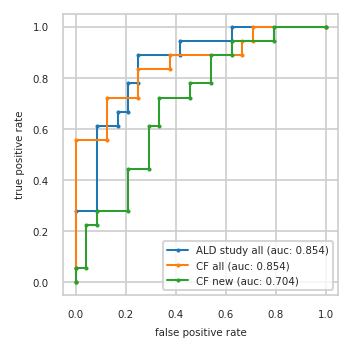

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.278  0.000 0.556  0.042 0.056
3          0.083 0.278  0.125 0.556  0.042 0.222
4          0.083 0.611  0.125 0.722  0.083 0.222
5          0.167 0.611  0.250 0.722  0.083 0.278
6          0.167 0.667  0.250 0.833  0.208 0.278
7          0.208 0.667  0.375 0.833  0.208 0.444
8          0.208 0.778  0.375 0.889  0.292 0.444
9          0.250 0.778  0.667 0.889  0.292 0.611
10         0.250 0.889  0.667 0.944  0.333 0.611
11         0.417 0.889  0.708 0.944  0.333 0.722
12         0.417 0.944  0.708 1.000  0.458 0.722
13         0.625 0.944  1.000 1.000  0.458 0.778
14         0.625 1.000    NaN   NaN  0.542 0.778
15         1.000 1.000    NaN   NaN  0.542 0.889
16           NaN   NaN    NaN   NaN  0.625 0.889
17           NaN   NaN    NaN   NaN  0.625 0.944
18           NaN   NaN    NaN   NaN  0.792 0.944
19           NaN   NaN    NaN   NaN  0.792 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,P31321
1,Q9NRN5,Q9NX62,E7EWD3;O75077;O75077-2;O75077-3
2,P09486,Q99983,Q96GD0
3,K7ERG9;P00746,P14174,Q9NUQ9
4,P14174,Q9Y2T3;Q9Y2T3-3,Q14894
5,P10636-2;P10636-6,P61981,P00568;Q5T9B7
6,P61981,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,A0A0C4DGY8;D6RA00;Q9UHY7,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
8,P18428,Q14894,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


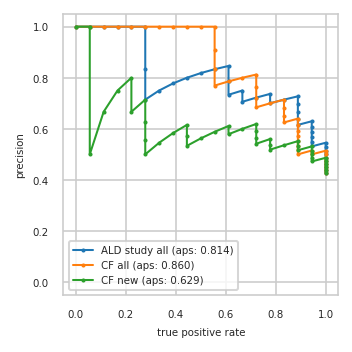

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.500 0.944     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.531 0.944     0.500 0.889     0.531 0.944
11         0.548 0.944     0.516 0.889     0.516 0.889
12         0.567 0.944     0.533 0.889     0.533 0.889
13         0.586 0.944     0.552 0.889     0.552 0.889
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.700 0.778     0.700 0.778     0.600 0.667
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.706 0.667     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.733 0.611     0.800 0.667     0.533 0.444
28         0.786 0.611     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.818 0.500     0.909 0.556     0.545 0.333
32         0.800 0.444     1.000 0.556     0.500 0.278
33         0.778 0.389     1.000 0.500     0.556 0.278
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.714 0.278     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


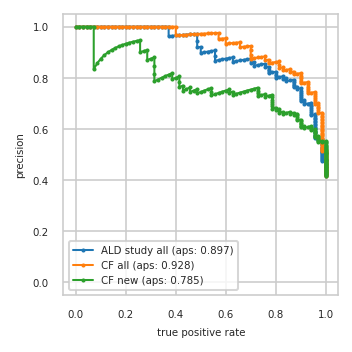

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


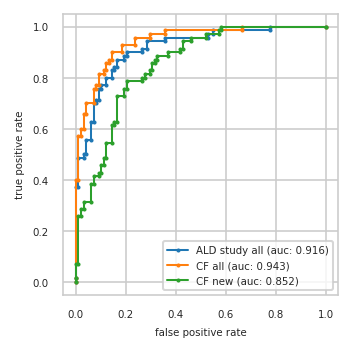

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}